## Matching evakuation
- Used 5 random donors
- Found their labeled images
- Found sequences (matches) for each labeld image
- Now here we are going to evaluate the purity of the clusters


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import cv2
import json

In [6]:
data = pd.read_csv("data/5random_donors_cleaned_clusters.uniq", names=['img','label','cluster_id'])

In [7]:
def eval_purity(data):
    clusters= data['cluster_id'].unique()
    purities = []
    for cluster in clusters:
        labels = data[data['cluster_id'] == cluster]['label']
        labels_count = labels.value_counts()
        count_of_dominant_class = labels_count.max()
        purity = count_of_dominant_class/labels.size
        purities.append(purity *100)
    return purities


purities = eval_purity(data)
print(np.mean(np.array(purities)))

95.23378707214111


(array([  1.,   5.,   1.,   1.,   1.,   1.,   2.,   5.,   1., 122.]),
 array([ 33.33333333,  40.        ,  46.66666667,  53.33333333,
         60.        ,  66.66666667,  73.33333333,  80.        ,
         86.66666667,  93.33333333, 100.        ]),
 <a list of 10 Patch objects>)

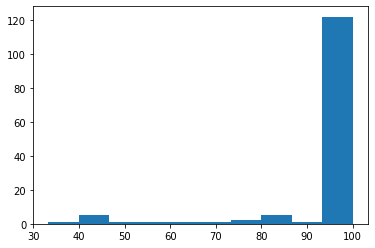

In [8]:
plt.hist(purities)

## Pairs

## odgt format pairs

In [9]:
def pair(filename, labeled_img_dir, all_img_dir, labels_dir, dest_filename, extension):
    df_seqs = pd.read_csv(filename , sep=",", names=['img', 'label', 'cluster_id'])
    h, w = 400, 600
    with open(dest_filename + ".odgt", "w") as fw:

        for img in glob.glob(labels_dir + '/*.png'):
            img_name = img.split("/")[-1]
            img_path = os.path.join(all_img_dir, img_name.replace(extension, ".JPG"))

            cluster_name = df_seqs[df_seqs['img'].str.contains(img_path.split('/')[-1])]
            if cluster_name.shape[0] > 0:
                cluster_name = cluster_name.reset_index(drop=True)['cluster_id'][0]
                seq_match = df_seqs[df_seqs['cluster_id'] == cluster_name].reset_index(drop=True)
                
                img_path = "/usb/sara_img/" + img_path

                if seq_match.shape[0] >= 2:
                    img_names = [img_path]
                    seg = labels_dir + img_name.split('.')[0] + '.png'
                    seg_names = [seg] * 2
                    for row in seq_match.iterrows():
                        if row[1].img not in img_names:
                            img_names.append("/usb/sara_img/" + row[1].img.split('/')[-1])
                        if len(img_names) == 2:
                            new_line = {}
                            new_line["fpath_img"], new_line["fpath_segm"], new_line["width"], new_line["height"] = \
                                    img_names, seg_names, w, h
                            json.dump(new_line, fw)
                            fw.write('\n')
                            img_names = [img_path]
                            seg_names = [seg] * 2

In [10]:
cluster_file = "/data/sara/semantic-segmentation-pytorch/data/5random_donors_cleaned_clusters.uniq"
dest_filename = "/data/sara/semantic-segmentation-pytorch/data/5random_donors_seqs_with_ann_pairs"
## only to get the pairs
labeled_img_dir = "/usb/sara_img/"    
all_img_dir = "/usb/sara_img/"
labels_dir = "/data/sara/semantic-segmentation-pytorch/all_body_part_annotations/"
extension = ".png"

In [11]:
pair(cluster_file, labeled_img_dir,all_img_dir ,labels_dir, dest_filename, extension)

## odgt format pairs + labels

In [12]:
def label_pairs(filename, labeled_img_dir, all_img_dir, labels_dir, dest_filename, extension):
    df_seqs = pd.read_csv(filename , sep=",", names=['img', 'label', 'cluster_id'])
    h, w = 400, 600
    with open(dest_filename + ".odgt", "w") as fw:

        for img in glob.glob(labels_dir + '/*.png'):
            img_name = img.split("/")[-1]
            img_path = os.path.join(all_img_dir, img_name.replace(extension, ".JPG"))


            matches = df_seqs[df_seqs['img'].str.contains(img_path.split('/')[-1])]
            if matches.shape[0] > 0:
                cluster_name = matches.reset_index(drop=True)['cluster_id'][0]
                label1 = matches.reset_index(drop=True)['label'][0]
                seq_match = df_seqs[df_seqs['cluster_id'] == cluster_name].reset_index(drop=True)
                
                #img_path = "/usb/sara_img/" + img_path
                if seq_match.shape[0] >= 2:
                    img_names = [img_path]
                    labels = [label1]
                    for row in seq_match.iterrows():
                        if row[1].img not in img_names:
                            img_names.append("/usb/sara_img/" + row[1].img.split('/')[-1])
                            labels.append(row[1].label)
                        if len(img_names) == 2:
                            new_line = {}
                            new_line["fpath_img"], new_line["fpath_segm"], new_line["width"], new_line["height"], new_line["same_class"] = \
                                    img_names, labels, w, h, labels[0] == labels[1]
                            json.dump(new_line, fw)
                            fw.write('\n')
                            img_names = [img_path]
                            labels = [label1]

In [13]:
label_pairs(cluster_file, labeled_img_dir,all_img_dir ,labels_dir, dest_filename + "_labeled", extension)


## before running the next block you should first remove the duplicates

In [14]:
df = pd.read_json("data/5random_donors_seqs_with_ann_pairs_labeled.odgt.uniq", lines=True)

In [15]:
df['same_class'].value_counts()

True     1272
False      66
Name: same_class, dtype: int64

In [16]:
good_pairs_percentage =  df[df['same_class'] == True].shape[0] /df.shape[0]

In [17]:
good_pairs_percentage

0.9506726457399103

In [ ]:
len(purities)

In [ ]:
#root@2a54cb8c6a49:/data/sara/semantic-segmentation-pytorch# data/5random_donors_seqs_with_ann_pairs_labeled.odgt | awk -F "," '{print $2}' | sort -u | wc -l
#818
#root@2a54cb8c6a49:/data/sara/semantic-segmentation-pytorch# cat 5random_donors_seqs_with_ann_pairs_labeled.odgt |wc -l
#12584
#root@2a54cb8c6a49:/data/sara/semantic-segmentation-pytorch# cat data/5random_donors_seqs_with_ann_pairs_labeled.odgt |sort -u |wc -l
#1338
#root@2a54cb8c6a49:/data/sara/semantic-segmentation-pytorch# cat 5random_donors_seqs_with_ann_pairs_labeled.odgt |sort -u  > 5random_donors_seqs_with_ann_pairs_labeled.odgt.uniq
#root@2a54cb8c6a49:/data/sara/semantic-segmentation-pytorch# cat data/5random_donors_cleaned_clusters | wc -l
#6027
#root@2a54cb8c6a49:/data/sara/semantic-segmentation-pytorch# cat data/5random_donors_cleaned_clusters | sort -u |wc -l
#1268
#root@2a54cb8c6a49:/data/sara/semantic-segmentation-pytorch# cat data/5random_donors_cleaned_clusters | sort -u > data/5random_donors_cleaned_clusters.uniq
#root@2a54cb8c6a49:/data/sara/semantic-segmentation-pytorch# cat data/5random_donors_seqs_with_ann_pairs_labeled.odgt| awk -F "," '{print $1}' | sort -u | wc -l
#107